In [58]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import gc, os
import time
from datetime import datetime
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #中文
pd.set_option("display.float_format", lambda x: "%.3f" % x) #避免显示问题，设置不显示科学计数法

- 目录：
- 序章：文件相关路径定义&读取源自特征工程后的结果：
>  trn_user_item_feats_df——训练用 + tst_user_item_feats_df——测试用；
- 预备流程：
> 1. 将排序结果处理成规定格式的函数；submit_sequence_result()；
——即将user_id,article_id,score返回成user_id,article_id12345的格式；
> 2. 将得分score标准化的函数；norm_sim()；
——即将ranker的score归一化到0-1区间，以便和classifier预测得到的proba可以融合；
- C1.LightGBM-Ranker做排序：——关键环节；
> 1. P1.数据准备：——拷一份儿保险；特征列要先制定好，不包含user_id,article_id；
>> 1. trn_user_item_feats_df_rank_model = trn_user_item_feats_df.copy()；
>> 2. tst_user_item_feats_df_rank_model = tst_user_item_feats_df.copy()；
> 2. P2.排序模型分组流程：
>> 1. trn_user_item_feats_df_rank_model：按照用户排序；其实是针对每一个用户的点击数据信息分组，组内就只包含该用户的几条数据信息；
>> 2.group_train每个用户有几条数据变成np.array——其实就是count(label)也就是数据条数；此参数，lgb_ranker里面要用一般都叫做g_train,g_val,g_test；这里为了强化记忆先这么写；
> 3. P3. 定义排序器lgb_ranker；
> 4. P4. 模型训练；
>> 1. 再解释一下ranker里面,fit时参数group的含义：就是该场景下因为是对每一个用户最后点击的一个物品进行预测，基础单位是用户，所以这个时候，每一个用户可以视为一个组；
> 5. P5.对测试集tst_user_item_feats_df_rank_model相关部分进行预测得分；
> 6. P6.将这里Ranker排序结果保存于本地； 在原始数据集tst_user_item_feats_df上增加predict_score字段；保存到指定路径；lgb_ranker_score.csv——后续模型融合会用；
> 7. P7.预测结果按照pred_score重新排序, 调用之前的submit_sequence_result()函数；生成模型标准推荐排序结果保留到本地相应路径；也可以将此结果命名为rank_results_seq_uncross，经过排序处理函数处理成要求格式，保存到本地指定：lgb_ranker_未交叉验证_日期.csv，可以参考结果；
> 8. P8.交叉验证看分数；——关键步骤：
>> 1. 将用户分为k_fold个样本群体，一份单独用来做验证集，另外k_fold-1份用来做训练；
>> 2. 建立模型后，每一轮的训练都会将其中当成验证集的那一部分——这里是按用户分组，所以就是对应用户的点击行为数据，模型根据这一部分会预测出这一部分用户对于每个文章物品的点击分数，排名；
>> 3. 最终所有的训练集用户相关都会得到自己的'user_id', 'click_article_id', 'pred_score', 'pred_rank'DF信息，拼接到一起，最终就是训练集+pred_score,rank；将[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']]信息保存到本地指定路径：trn_lgb_ranker_feats_result.csv；后续模型融合要使用；
>> 4. 与此同时，交叉验证过程中，每一轮都会模型再预测一下测试及对应数据的分数，最终所有次训练取平均值，最终得到一个测试集上pred_score，
保存到本地指定路径：tst_lgb_ranker_feats_result.csv，后续模型融合要使用；相比于上面得到的结果只少了一列label（废话。。。）；
> 9. P9.交叉验证后推荐排序结果也可以生成一份文件；保存到指定路径：lgb_ranker_交叉验证后_日期.csv
- C2.LightGBM-Classsifier做分类；从预测最终发生点击的概率大小角度来进行一个所谓的排序；
> 1. P1.定义一个LGBM分类器；
> 2. P2.训练模型；trn_user_item_feats_df_rank_model；
> 3. P3.分类器预测结果：对测试集tst_user_item_feats_df_rank_model相关部分进行预测得分；
> 4. P4.将分类0-1概率结果保存到本地指定路径；分别取属于正样本1类的概率；
> 5. P5.交叉验证使用！思路过程同上面的Ranker环节；
本地生成训练集结果：trn_lgb_classifier_feats_result.csv
本地生成测试集结果：tst_lgb_classifier_feats_result.csv
> 6. P6.交叉验证后推荐排序结果也可以生成一份文件；保存到指定路径：lgb_classifier_交叉验证后_日期.csv
- C3. 建设一个DNN神经网络试试；
> 1. P1.从训练集中拿出一部分作为验证用；
> 2. P2.建立DNN网络；
>> 
### S1.输入层和中间层；
- C4.模型融合；
> 1. P1.读取多个模型的排序结果文件；
> 2. P2.融合模型；
> 3. P3.神经网络特征标准化；
> 4. P4.重新定义一个DNN；生成新的预测结果保存到本地；
- C5.模型得分叠加处理；



# 序章.文件相关路径定义

In [59]:
data_path = './data_path/'            # 其实无用
save_path = './feature_project_path/' # 源于上次特征工程结果
save_dir = './sequence_result_path/'    # 最终排序结果存放位置
offline = False

# 序章.读取特征工程后的结果

In [60]:
# 重新读取数据的时候，发现click_article_id是一个浮点数，所以将其转换成int类型
trn_user_item_feats_df = pd.read_csv(save_path + 'trn_user_item_feats_df_final_sample.csv')
trn_user_item_feats_df['click_article_id'] = trn_user_item_feats_df['click_article_id'].astype(int)
if offline:
    val_user_item_feats_df = pd.read_csv(save_path + 'val_user_item_feats_df.csv')
    val_user_item_feats_df['click_article_id'] = val_user_item_feats_df['click_article_id'].astype(int)
else:
    val_user_item_feats_df = None
    
tst_user_item_feats_df = pd.read_csv(save_path + 'tst_user_item_feats_df_final_sample.csv')
tst_user_item_feats_df['click_article_id'] = tst_user_item_feats_df['click_article_id'].astype(int)

# 做特征的时候为了方便，给测试集也打上了一个无效的标签，这里直接删掉就行
del tst_user_item_feats_df['label']

# 预备工具I.定义排序结果的函数：
- 后面交叉验证用

In [61]:
# 返回排序结果处理函数
def submit_sequence_result(recall_df, filename, topk=5, model_name=None):
    '''
    recall_df:已经取出来的user_id,article_id,pred_score数据表df格式；
    filename：指定文件叫啥名，比如，未验证的排序，验证好的排序等；
    topk；得分前几名；
    model_name：用那个模型跑的；
    '''
    # 按照user_id,score排好序；
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])
    # 按照score值生成排序字段rank的值；
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    # 判断是不是每个用户都有5篇文章及以上，就是看每个用户下，rank值最大是多少；
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    # 保证判断结果为True的时候正常执行；
    assert tmp.min() >= topk
    # 分数拿掉；
    del recall_df['pred_score']
    # 把每个用户前五名的文章物品id拿出来设置用户id和rank排序值为联合索引；
    # 再使用unstack(-1)将rank排序rank转换成列，reset_index()，恢复索引
    submit_df = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()
    # 取消联合索引user_id、click_article_id、pred_score，MultiIndex形式，改为只留下1，2，3，4，5排序的信息
    submit_df.columns = [int(col) if isinstance(col, int) else col for col in submit_df.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit_df = submit_df.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2', 3: 'article_3', 4: 'article_4', 5: 'article_5'})
    save_name = save_dir + model_name + '_' + filename + '_'+ datetime.today().strftime('%Y-%m-%d') + '.csv'
    submit_df.to_csv(save_name, index=False, header=True)

# 预备工具II.排序结果分数归一化函数
- 后面模型融合时要用；

In [62]:
# 排序结果分数归一化函数
def norm_sim(sim_df, weight=0.0):
    # print(sim_df.head())
    min_sim = sim_df.min()
    max_sim = sim_df.max()
    if max_sim == min_sim:
        sim_df = sim_df.apply(lambda sim: 1.0)
    else:
        sim_df = sim_df.apply(lambda sim: 1.0 * (sim - min_sim) / (max_sim - min_sim))

    sim_df = sim_df.apply(lambda sim: sim + weight)  # plus one
    return sim_df

# C1.LightGBM-Ranker做排序！
- 1.得到根据召回分数，模型训练预测出的分数score进行排序；
- 2.根据分数最终对测试集返回对应的排序结果；

## P1.数据准备

In [63]:
# 复制一份训练测试的数据
trn_user_item_feats_df_rank_model = trn_user_item_feats_df.copy()
if offline:
    val_user_item_feats_df_rank_model = val_user_item_feats_df.copy() 
tst_user_item_feats_df_rank_model = tst_user_item_feats_df.copy()

In [64]:
# 需要用到的特征列；
lgb_ranker_need_cols = ['sim0', 'time_diff0', 'word_diff0',
       'sim_max', 'sim_min', 'sim_sum', 'sim_mean', 'sim_median', 'score',
       'rank', 'click_size', 'time_diff_mean', 'active_level_parameter',
       'click_environment', 'click_deviceGroup', 'click_os', 'click_country',
       'click_region', 'click_referrer_type', 'click_weekday', 'click_hour',
       'article_crt_weekday', 'article_crt_hour', 'words_hbo', 'category_id',
       'words_count']

## P2.排序模型分组流程：
- 1.trn_user_item_feats_df_rank_model：按照用户排序；
- 2.group_train每个用户有几条数据变成np.array——其实就是count(label)也就是数据条数；此参数，lgb_ranker里面要用
- 一般都叫做g_train,g_val,g_test

In [65]:
trn_user_item_feats_df_rank_model.sort_values(by=['user_id'], inplace=True)
group_train = trn_user_item_feats_df_rank_model.groupby(['user_id'], as_index=False).count()["label"].values

## P3.定义LGBM排序器

In [66]:
lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1, max_depth=-1, n_estimators=163, subsample=0.8, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=0, n_jobs= -1) 
# min_child_weight代表的意思是，儅一個節點下的樣本數小於給定的閾值时，停止生长，会被剪枝；太高会欠拟合，太低容易过拟合；
# 这个值定的高，则每个叶子节点越容易被剪枝掉，过高就产生欠拟合状态；过低，好多叶子结点就不会被剪掉，叶子生长过多，容易过拟合；
# 树的生长，越浅，叶子包含样本越不纯，被剪枝得厉害，越欠拟合；越深，叶子包含样本越纯，剪枝少，容易过拟合；
# colsample_bytree：构建每一弱评估器的子采样比例；

## P4.初次训练
- 实例化保存结果；lgb_ranker_re
- 解释一下参数group的含义：
> 1. 就是该场景下因为是对每一个用户最后点击的一个物品进行预测，基础单位是用户，所以这个时候，每一个用户可以视为一个组

In [67]:
# 划分测试集和训练集
X_train = trn_user_item_feats_df_rank_model[lgb_ranker_need_cols]
y_train = trn_user_item_feats_df_rank_model['label']
X_test  = tst_user_item_feats_df_rank_model[lgb_ranker_need_cols]# 不推荐这么写，后面你就知道了；还得往回重新粘

In [68]:
lgb_ranker_re = lgb_ranker.fit(trn_user_item_feats_df_rank_model[lgb_ranker_need_cols], trn_user_item_feats_df_rank_model['label'], group=group_train)

## P5.模型预测得分；

In [70]:
# 模型预测，
# X_test['pred_score'] = lgb_ranker_re.predict(X_test, num_iteration=lgb_ranker_re.best_iteration_) # 省得还得重新网上拼接
# 这个pred_score字段名不要瞎改！
tst_user_item_feats_df['pred_score'] = lgb_ranker_re.predict(tst_user_item_feats_df[lgb_ranker_need_cols], num_iteration=lgb_ranker_re.best_iteration_)

In [71]:
tst_user_item_feats_df

,user_id,click_article_id,sim0,time_diff0,word_diff0,sim_max,sim_min,sim_sum,sim_mean,sim_median,...,click_referrer_type,click_weekday,click_hour,article_crt_weekday,article_crt_hour,words_hbo,category_id,words_count,is_cat_hab,pred_score
0,200000,191916,0.809,657135000,46,0.809,0.809,0.809,0.809,0.809,...,1,2,11,2,6,200.333,309,156,1,0.886
1,200642,191916,0.888,32373000,21,0.888,0.888,0.888,0.888,0.888,...,1,2,11,2,6,177.000,309,156,0,-1.884
2,203147,191916,0.703,22131000,46,0.703,0.703,0.703,0.703,0.703,...,1,2,9,1,15,194.000,309,156,0,-1.869
3,203448,191916,0.888,32373000,21,0.888,0.888,0.888,0.888,0.888,...,1,2,9,2,6,177.000,309,156,0,-1.884
4,203655,191916,0.888,32373000,21,0.888,0.888,0.888,0.888,0.888,...,1,2,9,2,6,165.000,309,156,0,-1.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,249872,206624,0.787,6015658000,104,0.787,0.787,0.787,0.787,0.787,...,1,3,16,2,10,224.370,331,201,1,-1.881
999996,249872,106213,0.730,11025659000,180,0.730,0.730,0.730,0.730,0.730,...,1,3,16,2,10,224.370,228,125,1,-1.914
999997,249933,355995,0.406,167018369000,42,0.406,0.406,0.406,0.406,0.406,...,2,3,17,3,12,198.156,450,167,0,-1.779
999998,249961,326992,0.071,1094791000,14,0.071,0.071,0.071,0.071,0.071,...,1,1,15,3,4,201.333,435,148,1,-1.839


In [13]:
# tst_user_item_feats_df[tst_user_item_feats_df["user_id"]==200000]

## P6.将这里Ranker排序结果保存于本地；——后续模型融合要用到；

In [14]:
tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']].to_csv(save_dir + 'lgb_ranker_score.csv', index=False)

## P7.预测结果按照pred_score重新排序, 调用之前的submit 函数；生成模型标准排序结果保留到本地相应路径；
- 1.模型预测出的结果pred_score和user,article_id,pred_score取出单独拿出来；
- 2.文章id字段需要转换成整数型；

In [15]:
rank_results_seq_uncross = tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']]
rank_results_seq_uncross['click_article_id'] = rank_results_seq_uncross['click_article_id'].astype(int)
submit_sequence_result(rank_results_seq_uncross,'未交叉验证', topk=5, model_name='lgb_ranker') 

## P8.使用交叉验证看分数；——关键步骤；

In [16]:
# 原版五折交叉验证，这里的六折交叉是以用户为目标进行六折划分
# 这一部分与前面的单独训练和验证是分开的
# 交叉验证次数6；k_fold
k_fold = 6
# 一份训练用的数据copy一下；trn_df
trn_df_ranker = trn_user_item_feats_df_rank_model
# 把训练集用户单独拿出来；user_ids
user_ids_ranker = trn_df_ranker['user_id'].unique()
# 定义用户训练分组函数，思想就是每隔n个取一个，[0,6,12......]，[1,7,13......]
def get_kfold_users(trn_df_ranker, n = 6):
    user_ids_ranker = trn_df_ranker['user_id'].unique()
    user_set_ranker = [user_ids_ranker[i::n] for i in range(n)]
    return user_set_ranker
# 使用分组函数得到几组用户；
user_set_ranker = get_kfold_users(trn_df_ranker, n=k_fold)
# 生成空列表，为了储存训练集的交叉验证分数、排序结果；
score_list_ranker = []
# 目标三列拿来，所有user_id,click_article_id,label
score_df_ranker = trn_df_ranker[['user_id', 'click_article_id','label']]
# 最终测试集分数准备，先都默认用np.zeros打0；sub_preds_points_ranker
sub_preds_points_ranker = np.zeros(tst_user_item_feats_df_rank_model.shape[0])
# n折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set_ranker):
    '''
    n_fold：交叉验证划分用户组的组序号；
    valid_user：每组的用户列表array；
    '''
    # 遍历该组用户时，该组用户的相关数据信息作为测试集用来验证分数，剩下的都是训练集；再啰嗦一遍；
    train_idx = trn_df_ranker[~trn_df_ranker['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df_ranker[trn_df_ranker['user_id'].isin(valid_user)]
    # 训练集与验证集的用户分组排序：
    train_idx.sort_values(by=['user_id'], inplace=True)
    g_train = train_idx.groupby(['user_id'], as_index=False).count()["label"].values
    # 验证集：
    valid_idx.sort_values(by=['user_id'], inplace=True)
    g_val = valid_idx.groupby(['user_id'], as_index=False).count()["label"].values
    # 定义模型，简单设置一下框架先；
    lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,max_depth=-1, n_estimators=163, 
                                subsample=0.8, colsample_bytree=0.7, subsample_freq=1,learning_rate=0.01, min_child_weight=50, 
                                random_state=0, n_jobs= -1, silent = False) 
    # 训练模型
    lgb_ranker_re = lgb_ranker.fit(train_idx[lgb_ranker_need_cols], train_idx['label'], group=g_train,
                                   eval_set=[(valid_idx[lgb_ranker_need_cols], valid_idx['label'])], eval_group= [g_val], 
                                   eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg', ], early_stopping_rounds=50)
    # 对验证集预测结果
    # 留一行注释警示作用——为什么pred_score不要重新命名了；
    # valid_idx['pred_score_ranker'] = lgb_ranker_re.predict(valid_idx[lgb_ranker_need_cols], num_iteration=lgb_ranker_re.best_iteration_)
    valid_idx['pred_score'] = lgb_ranker_re.predict(valid_idx[lgb_ranker_need_cols], num_iteration=lgb_ranker_re.best_iteration_)
    # num_iteration参数：如果在训练期间启用了早期停止，可以通过best_iteration方式从最佳迭代中获得预测
    # 对验证集按照用户，分数排序，并生成排序结果字段rank；
    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    # 将验证集的预测结果放到一个列表中，后面进行拼接叠加；每一次得到的都是用户平均分组的群体信息
    score_list_ranker.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])
    # 验证集的分数每一条数据，就是user_id-article_id-label-得到一个predict_score，一共k_fold轮，每一轮进行自叠加运算
    # k_fold轮以后添加到sub_preds_points：
    # 实际记录的是所有k_fold轮交叉验证以后,验证集中每一条就是每一个用户对于一个文章物品的分数（类似于概率），
    # 所有轮加起来，最终就是所有训练集所包含的所有每个用户user_id,article_id的pred_score,pred_rank信息；
    if not offline:
        sub_preds_points_ranker += lgb_ranker_re.predict(tst_user_item_feats_df_rank_model[lgb_ranker_need_cols], lgb_ranker_re.best_iteration_)
# k_fold次划分的用户，这回都有了得分信息，把所有的纵向叠加起来合并形成score_df；
score_df_ranker_ = pd.concat(score_list_ranker, axis=0)
score_df_ranker = score_df_ranker.merge(score_df_ranker_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新信息——pred_score，pred_rank保存，后续会有用
# 将交叉验证对于训练集的结果保存下来；——后续模型融合要用；
score_df_ranker[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_dir + 'trn_lgb_ranker_feats_result.csv', index=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3723
[LightGBM] [Info] Number of data points in the train set: 342100, number of used features: 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[5]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	va

[49]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3716
[LightGBM] [Info] Number of data points in the train set: 342055, number of used features: 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3719
[LightGBM] [Info] Number of data points in the train set: 342151, number of used features: 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0'

[49]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3723
[LightGBM] [Info] Number of data points in the train set: 342093, number of used features: 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1

[49]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3719
[LightGBM] [Info] Number of data points in the train set: 342093, number of used features: 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3717
[LightGBM] [Info] Number of data points in the train set: 341998, number of used features: 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[5]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	va

[49]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1


## P9.测试集，基于先前交叉验证的多次结果进行平均化；本保存到本地一份结果；
- 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于模型融合后面的操作。。。

In [17]:
# 刚才交叉验证环节中，对于最终测试集预测的分数取平均值；为什么要取平均值？——废话再说一遍，泛化验证的思想；
# 再按照user_id,分数排序；再按照分数高低，生成排序字段pred_rank；
# 测试集由于数据要提交，保持和前面submit_sequence_result函数要求的字段一致；
tst_user_item_feats_df_rank_model['pred_score'] = sub_preds_points_ranker/k_fold
tst_user_item_feats_df_rank_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_rank_model['pred_rank'] = tst_user_item_feats_df_rank_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_dir + 'tst_lgb_ranker_feats_result.csv', index=False)

In [18]:
# 预测结果重新排序, 及生成提交结果
# 单模型生成提交结果
# 与P7提交的结果相比有差别！
rank_results_seq_crossed = tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score']]
rank_results_seq_crossed['click_article_id'] = rank_results_seq_crossed['click_article_id'].astype(int)
submit_sequence_result(rank_results_seq_crossed,'交叉验证后', topk=5, model_name='lgb_ranker') 

# C2.LightGBM-Classsifier做分类！

## P1.定义一个LGBM分类器；
- 1.得到根据召回分数等特征，模型训练预测出的概率proba进行排序；
- 2.根据概率大小最终对测试集返回对应的排序结果；

In [19]:
# 模型及参数的定义，随便定义一个
lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=163, subsample=0.8, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=63, random_state=0, n_jobs= -1, verbose=10, silent=False)  

## P2.训练模型

In [20]:
lgb_Classfication_re = lgb_Classfication.fit(trn_user_item_feats_df_rank_model[lgb_ranker_need_cols], trn_user_item_feats_df_rank_model['label']) 

[LightGBM] [Info] Number of positive: 197496, number of negative: 213002
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.071776
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.036396 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3720
[LightGBM] [Info] Number of data points in the train set: 410498, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481113 -> initscore=-0.075583
[LightGBM] [Info] Start training from score -0.075583
[LightGBM] [Debug] Re-bagging, using 328542 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Re-bagging, using 328102 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 7
[LightGBM] [Debug] Re-bagging, using 328081 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328551 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328378 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328868 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328342 data to train
[LightGBM] [War

[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328327 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328310 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 6
[LightGBM] [Debug] Re-bagging, using 328607 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Debug] Re-bagging, using 328498 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328583 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328170 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328345 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328299 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Debug] Re-bagging, using 328267 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Re-bagging, using 328073 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Deb

## P3.分类器预测结果：

In [21]:
# 模型预测，返回概率；
tst_user_item_feats_df['pred_score'] = lgb_Classfication_re.predict_proba(tst_user_item_feats_df[lgb_ranker_need_cols])[:,1]

## P4.将分类0-1概率结果保存到本地指定路径

In [22]:
# 将这里的按照分类概率结果结果保存一份
tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']].to_csv(save_dir + 'lgb_classfier_score.csv', index=False)

In [23]:
# 预测结果重新排序, 及生成提交结果；
rank_results_classifier_uncross = tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']]
rank_results_classifier_uncross['click_article_id'] = rank_results_classifier_uncross['click_article_id'].astype(int)
submit_sequence_result(rank_results_classifier_uncross,'未交叉验证', topk=5, model_name='lgb_classifier')

## P5.交叉验证仍然！同时处理测试集的交叉验证分数；

In [24]:
# 交叉验证次数6；k_fold
k_fold = 6
# 一份训练用的数据copy一下；
trn_df_classifier = trn_user_item_feats_df_rank_model
# 把训练集用户单独拿出来；user_ids
user_ids_classifier = trn_df_classifier['user_id'].unique()
#  与前面排序阶段是类似的，这里函数不再重新说明
def get_kfold_users(trn_df, n = 6):
    user_ids_classifier = trn_df_classifier['user_id'].unique()
    user_set_classifier = [user_ids_classifier[i::n] for i in range(n)]
    return user_set_classifier
user_set_classifier = get_kfold_users(trn_df_classifier, n=k_fold)
# 生成空列表，为了储存交叉验证分数；
score_list_classifier = []
score_df_classifier = trn_df_classifier[['user_id', 'click_article_id', 'label']]
# 定义测试集分类器分数收集数组
sub_preds_points_classifier = np.zeros(tst_user_item_feats_df_rank_model.shape[0])
# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set_classifier):
    train_idx = trn_df_classifier[~trn_df_classifier['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df_classifier[trn_df_classifier['user_id'].isin(valid_user)]
    
    # 模型及参数的定义
    lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=163, subsample=0.8, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=52, random_state=0, n_jobs= 16, verbose=10)  
    # 训练模型
    lgb_Classfication_re = lgb_Classfication.fit(train_idx[lgb_ranker_need_cols], train_idx['label'],eval_set=[(valid_idx[lgb_ranker_need_cols], valid_idx['label'])], 
                          eval_metric=['auc', ],early_stopping_rounds=50, )
    
    # 预测验证集结果
    valid_idx['pred_score'] = lgb_Classfication_re.predict_proba(valid_idx[lgb_ranker_need_cols], 
                                                              num_iteration=lgb_Classfication.best_iteration_)[:,1]
    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    # 将验证集的预测结果放到一个列表中，后面进行拼接
    score_list_classifier.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])
    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds_points_classifier += lgb_Classfication.predict_proba(tst_user_item_feats_df_rank_model[lgb_ranker_need_cols], 
                                                     num_iteration=lgb_Classfication_re.best_iteration_)[:,1]
score_df_classifier_ = pd.concat(score_list_classifier, axis=0)
score_df_classifier = score_df_classifier.merge(score_df_classifier_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新特征
score_df_classifier[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_dir + 'trn_lgb_classifier_feats_result.csv', index=False)


# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
tst_user_item_feats_df_rank_model['pred_score'] = sub_preds_points_classifier / k_fold
tst_user_item_feats_df_rank_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_rank_model['pred_rank'] = tst_user_item_feats_df_rank_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_dir + 'tst_lgb_classifier_feats_result.csv', index=False) 

[LightGBM] [Info] Number of positive: 164580, number of negative: 177520
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.071684
[LightGBM] [Debug] init for col-wise cost 0.000014 seconds, init for row-wise cost 0.028860 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3724
[LightGBM] [Info] Number of data points in the train set: 342100, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481087 -> initscore=-0.075687
[LightGBM] [Info] Start training from score -0.075687
[LightGBM] [Debug] Re-bagging, using 273746 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.682493
[LightGBM] [Debug] Re-bagging, using 273382 data to train
[LightGBM] [

[LightGBM] [Debug] Re-bagging, using 273762 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[43]	valid_0's auc: 1	valid_0's binary_logloss: 0.402285
[LightGBM] [Debug] Re-bagging, using 273312 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[44]	valid_0's auc: 1	valid_0's binary_logloss: 0.397355
[LightGBM] [Debug] Re-bagging, using 273632 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[45]	valid_0's auc: 1	valid_0's binary_logloss: 0.392532
[LightGBM] [Debug] Re-bagging, using 273425 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[46]	valid_0's auc: 1	valid_0's binary_lo

[LightGBM] [Debug] Re-bagging, using 273823 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[32]	valid_0's auc: 1	valid_0's binary_logloss: 0.461869
[LightGBM] [Debug] Re-bagging, using 273475 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[33]	valid_0's auc: 1	valid_0's binary_logloss: 0.456024
[LightGBM] [Debug] Re-bagging, using 273596 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[34]	valid_0's auc: 1	valid_0's binary_logloss: 0.450312
[LightGBM] [Debug] Re-bagging, using 273501 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[35]	valid_0's auc: 1	valid_0's binary_

[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[23]	valid_0's auc: 1	valid_0's binary_logloss: 0.51901
[LightGBM] [Debug] Re-bagging, using 273934 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[24]	valid_0's auc: 1	valid_0's binary_logloss: 0.512235
[LightGBM] [Debug] Re-bagging, using 273838 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 6
[25]	valid_0's auc: 1	valid_0's binary_logloss: 0.505618
[LightGBM] [Debug] Re-bagging, using 274113 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[26]	valid_0's auc: 1	valid_0's binary_logloss: 0.499066
[LightGBM] [Debug] Re-bagging, using 273962 data to train
[LightGBM] [Warning] No further splits with positive gain, 

[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.656625
[LightGBM] [Debug] Re-bagging, using 273756 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.647428
[LightGBM] [Debug] Re-bagging, using 273839 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[7]	valid_0's auc: 1	valid_0's binary_logloss: 0.638356
[LightGBM] [Debug] Re-bagging, using 273618 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[8]	valid_0's auc: 1	valid_0's binary_logloss: 0.629456
[LightGBM] [Debug] Re-bagging, using 273520 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 a

[LightGBM] [Debug] Re-bagging, using 273629 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[45]	valid_0's auc: 1	valid_0's binary_logloss: 0.392626
[LightGBM] [Debug] Re-bagging, using 273422 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[46]	valid_0's auc: 1	valid_0's binary_logloss: 0.387839
[LightGBM] [Debug] Re-bagging, using 273872 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[47]	valid_0's auc: 1	valid_0's binary_logloss: 0.383122
[LightGBM] [Debug] Re-bagging, using 273647 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[48]	valid_0's auc: 1	valid_0's binary_l

[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[30]	valid_0's auc: 1	valid_0's binary_logloss: 0.473767
[LightGBM] [Debug] Re-bagging, using 273583 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[31]	valid_0's auc: 1	valid_0's binary_logloss: 0.467733
[LightGBM] [Debug] Re-bagging, using 273858 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[32]	valid_0's auc: 1	valid_0's binary_logloss: 0.461795
[LightGBM] [Debug] Re-bagging, using 273502 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[33]	valid_0's auc: 1	valid_0's binary_logloss: 0.455952
[LightGBM] [Debug] Re-bagging, using 273630 data to train
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Debug] Re-bagging, using 273237 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[15]	valid_0's auc: 1	valid_0's binary_logloss: 0.571621
[LightGBM] [Debug] Re-bagging, using 273383 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[16]	valid_0's auc: 1	valid_0's binary_logloss: 0.563941
[LightGBM] [Debug] Re-bagging, using 273607 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[17]	valid_0's auc: 1	valid_0's binary_logloss: 0.561815
[LightGBM] [Debug] Re-bagging, using 273493 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[18]	valid_0's auc: 1	valid_0's binary_logloss: 0.554307
[LightGBM] [Debug] Re-bagging, using 273051 data to train

## P6.再生成结果到本地！

In [25]:
# 再次预测结果重新排序, 及生成提交结果
rank_results_classifier_crossed = tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score']]
rank_results_classifier_crossed['click_article_id'] = rank_results_classifier_crossed['click_article_id'].astype(int)
submit_sequence_result(rank_results_classifier_crossed,'交叉验证后', topk=5, model_name='lgb_classifier')

# C3.建设一个DNN神经网络试试；
利用keras中的DNN建立一个神经网络看一下结果；

In [26]:
import tensorflow as tf
from tensorflow import keras

## P1.从训练集中拿出一部分作为验证用；

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_need_train = trn_user_item_feats_df_rank_model[lgb_ranker_need_cols]
y_need_train = trn_user_item_feats_df_rank_model['label']
# y_need_train = to_categorical(trn_user_item_feats_df_rank_model['label'])# Tensor要转一下
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(X_need_train,y_need_train,test_size=0.3,random_state=0)
X_train_dnn.shape,y_train_dnn.shape,X_val_dnn.shape,y_val_dnn.shape

((287348, 26), (287348,), (123150, 26), (123150,))

## P2.建立DNN网络；
### S1.输入层和中间层；
- 先设置三层隐藏层，每一层10个神经元；激活函数选用relu；
- 每一层隐藏层后面加一个标准化层；
- 最终加一个Alpha正则化层；


In [28]:
# 定义一个DNN
model_DNN = keras.models.Sequential()
model_DNN.add(keras.layers.Flatten(input_shape = [26, 1]))  # flatten层的作用是将28*28维度的输入数据展平成一层，输入层；虽然本就是一维
for _ in range(4):
    # 隐藏层的激活函数都选用relu，如果选用selu自带归一化功能；
    model_DNN.add(keras.layers.Dense(30, activation = "relu"))
    # 隐藏层加入标准化模块加速训练速度，将前一层的激活值重新规范化，即使得其输出数据的均值接近0，其标准差接近1；
    model_DNN.add(keras.layers.BatchNormalization()) 
model_DNN.add(keras.layers.AlphaDropout(rate=0.5))  # 正则化层；


### S2.输出层；
- len(pd.Series(y_val_dnn).unique())这样写就不用了写2了。。。

In [29]:
model_DNN.add(keras.layers.Dense(len(pd.Series(y_val_dnn).unique()), activation = "softmax")) 
model_DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 26)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                810       
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                1

## P2.定义模型训练器，训练数据；

In [30]:
# # 定义训练历史；
# train_history = model_DNN.fit(X_need_train, y_need_train, batch_size = 1000, epochs=6)
# history_frame = pd.DataFrame(train_history.history)
# history_frame['epoch'] = train_history.epoch
# history_frame['epoch'] = history_frame['epoch'] + 1
# def plot_history(hist):
#     plt.figure(figsize=(10,5))
#     plt.subplot(1, 2, 1)
#     plt.xlabel('Epoch')
#     plt.ylabel('accuracy')
#     plt.plot(hist['epoch'], hist['accuracy'],label='accuracy')
#     plt.legend()
# plot_history(history_frame)    
model_DNN.compile(
             loss = "sparse_categorical_crossentropy",  # 稀疏分类交叉熵损失函数
             optimizer = keras.optimizers.Adam(learning_rate = 0.0001),    # 优化函数为随机梯度下降 ，学习率为0.01
             metrics = ["accuracy"])                     # 优化指标为准确度
# 记录训练历史
model_DNN_train_history = model_DNN.fit(X_train_dnn, y_train_dnn,             # 训练数据
                                        batch_size=3000,                       # 每一次迭代传入5000样本；
                                        epochs = 20,                           # 训练周期，数据分为10次进行训练
                                        validation_data = (X_val_dnn, y_val_dnn),) # 验证集要用；

Epoch 1/20
96/96 [==============================] - 3s 9ms/step - loss: 0.8514 - accuracy: 0.5596 - val_loss: 0.6268 - val_accuracy: 0.5029
Epoch 2/20
96/96 [==============================] - 1s 7ms/step - loss: 0.7708 - accuracy: 0.5949 - val_loss: 0.6099 - val_accuracy: 0.5086
Epoch 3/20
96/96 [==============================] - 1s 7ms/step - loss: 0.7401 - accuracy: 0.6073 - val_loss: 0.5890 - val_accuracy: 0.5242
Epoch 4/20
96/96 [==============================] - 1s 7ms/step - loss: 0.7147 - accuracy: 0.6152 - val_loss: 0.5675 - val_accuracy: 0.6765
Epoch 5/20
96/96 [==============================] - 1s 7ms/step - loss: 0.6976 - accuracy: 0.6173 - val_loss: 0.5789 - val_accuracy: 0.6782
Epoch 6/20
96/96 [==============================] - 1s 7ms/step - loss: 0.6854 - accuracy: 0.6178 - val_loss: 0.6045 - val_accuracy: 0.6726
Epoch 7/20
96/96 [==============================] - 1s 7ms/step - loss: 0.6745 - accuracy: 0.6213 - val_loss: 0.6201 - val_accuracy: 0.6782
Epoch 8/20
96/96 [==

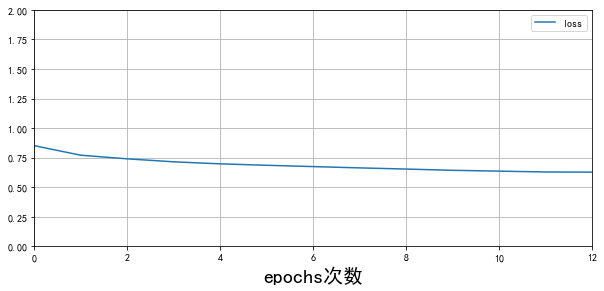

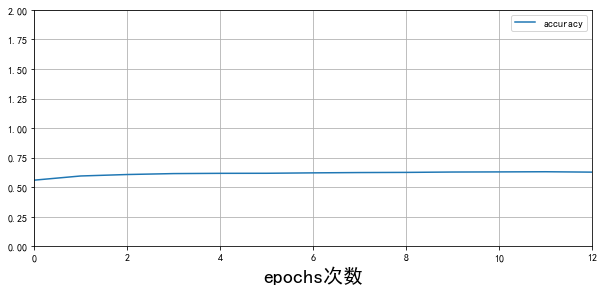

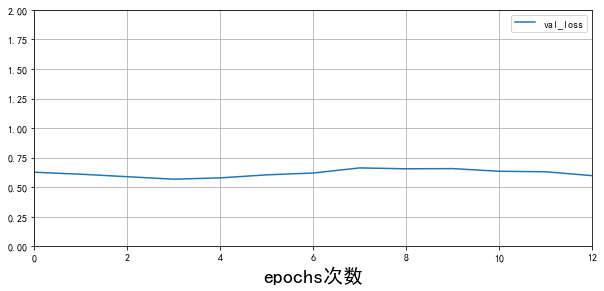

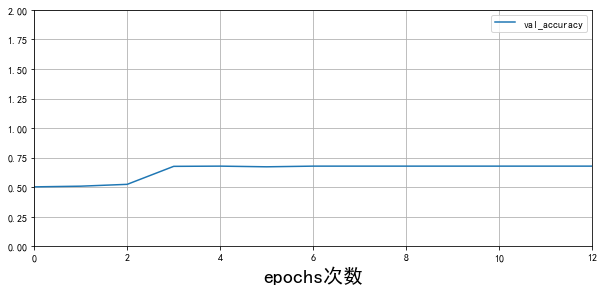

In [31]:
for i,j in enumerate(model_DNN_train_history.history):
    plt.figure(figsize=(10,20))
    plt.subplot(4,1,i+1)
    plt.plot(range(len(model_DNN_train_history.history[j])),model_DNN_train_history.history[j],label = j)
    plt.grid(True)
    plt.gca().set_xlim(0, 12)
    plt.gca().set_ylim(0, 2)
    plt.legend()
    plt.xlabel("epochs次数",fontsize = 20)

- 可以看出效果很差，损失基本不变；
- 尝试将原来特征都进行标准化；

## P3.神经网络特征标准化；
- 所有数值型特征都标准化处理；

In [32]:
from sklearn.preprocessing import MinMaxScaler
need_feature = ["sim0","time_diff0","word_diff0","sim_max","sim_min","sim_sum","sim_mean","sim_median","score","words_hbo","words_count"]
mm_Scaler = MinMaxScaler()
X_need_feature = mm_Scaler.fit_transform(X_train[need_feature])
X_train_DNN_need_feature = pd.DataFrame(X_need_feature,columns = [(str(i) + "_new") for i in X_train[need_feature].columns])
X_train_DNN_new = pd.concat([X_train_DNN_need_feature,X_train.drop(need_feature,axis=1)],axis=1)
# 测试集亦如此
X_test_need_feature = mm_Scaler.fit_transform(X_test[need_feature])
X_test_DNN_need_feature = pd.DataFrame(X_test_need_feature,columns = [(str(i) + "_new") for i in X_test[need_feature].columns])
X_test_DNN_new = pd.concat([X_test_DNN_need_feature,X_test.drop(need_feature,axis=1)],axis=1)
X_train_DNN_new,X_val_DNN_new,Y_train_DNN_new,Y_val_DNN_new = train_test_split(X_train_DNN_new,y_train,test_size=0.2,random_state=0)

In [33]:
X_train_DNN_new.shape,y_train.shape

((328398, 26), (410498,))

## P4.重新定义一个DNN；
### S1.定义；

In [53]:
model_DNN_new = keras.models.Sequential()
model_DNN_new.add(keras.layers.Flatten(input_shape = [26, 1]))  # flatten层的作用是将28*28维度的输入数据展平成一层，输入层；虽然本就是一维
for _ in range(4):
    model_DNN_new.add(keras.layers.Dense(26, activation = "relu"))
    # 隐藏层加入标准化模块加速训练速度，将前一层的激活值重新规范化，即使得其输出数据的均值接近0，其标准差接近1；
    model_DNN_new.add(keras.layers.BatchNormalization()) 
model_DNN_new.add(keras.layers.AlphaDropout(rate=0.5))  # 正则化层；
model_DNN_new.add(keras.layers.Dense(len(pd.Series(Y_val_DNN_new).unique()), activation = "softmax")) # 输出层别忘。。。
model_DNN_new.compile(
             loss = "sparse_categorical_crossentropy",  # 稀疏分类交叉熵损失函数
             optimizer = keras.optimizers.Adam(learning_rate = 0.0003),    # 优化函数为随机梯度下降 ，学习率为0.01
             metrics = ["accuracy"])                     # 优化指标为准确度
# 记录训练历史
model_DNN__new_train_history = model_DNN_new.fit(X_train_DNN_new, Y_train_DNN_new,             # 训练数据
                                        batch_size = 700,                       # 每一次迭代传入样本；
                                        epochs = 80,                           # 训练周期
                                        validation_data = (X_val_DNN_new, Y_val_DNN_new),) # 验证集要用；

Epoch 1/80
470/470 [==============================] - 3s 3ms/step - loss: 0.8622 - accuracy: 0.5042 - val_loss: 0.7034 - val_accuracy: 0.5266
Epoch 2/80
470/470 [==============================] - 1s 3ms/step - loss: 0.7226 - accuracy: 0.5348 - val_loss: 0.7901 - val_accuracy: 0.5179
Epoch 3/80
470/470 [==============================] - 1s 3ms/step - loss: 0.6269 - accuracy: 0.6298 - val_loss: 0.8319 - val_accuracy: 0.5334
Epoch 4/80
470/470 [==============================] - 1s 3ms/step - loss: 0.6030 - accuracy: 0.6520 - val_loss: 0.8612 - val_accuracy: 0.5335
Epoch 5/80
470/470 [==============================] - 1s 3ms/step - loss: 0.5948 - accuracy: 0.6587 - val_loss: 0.6722 - val_accuracy: 0.6682
Epoch 6/80
470/470 [==============================] - 1s 3ms/step - loss: 0.5876 - accuracy: 0.6643 - val_loss: 0.8350 - val_accuracy: 0.5733
Epoch 7/80
470/470 [==============================] - 1s 3ms/step - loss: 0.5848 - accuracy: 0.6668 - val_loss: 0.7002 - val_accuracy: 0.6702
Epoch 

470/470 [==============================] - 1s 3ms/step - loss: 0.5616 - accuracy: 0.6787 - val_loss: 0.9021 - val_accuracy: 0.6741
Epoch 59/80
470/470 [==============================] - 1s 3ms/step - loss: 0.5274 - accuracy: 0.7125 - val_loss: 2.7107 - val_accuracy: 0.6754
Epoch 60/80
470/470 [==============================] - 1s 3ms/step - loss: 0.4635 - accuracy: 0.7791 - val_loss: 3.8817 - val_accuracy: 0.6728
Epoch 61/80
470/470 [==============================] - 1s 3ms/step - loss: 0.4068 - accuracy: 0.8214 - val_loss: 3.9644 - val_accuracy: 0.6743
Epoch 62/80
470/470 [==============================] - 1s 3ms/step - loss: 0.3531 - accuracy: 0.8578 - val_loss: 4.1829 - val_accuracy: 0.6783
Epoch 63/80
470/470 [==============================] - 1s 3ms/step - loss: 0.3067 - accuracy: 0.8847 - val_loss: 4.1238 - val_accuracy: 0.6862
Epoch 64/80
470/470 [==============================] - 1s 3ms/step - loss: 0.2812 - accuracy: 0.8978 - val_loss: 1.2709 - val_accuracy: 0.5299
Epoch 65/80

### S2.训练结果；

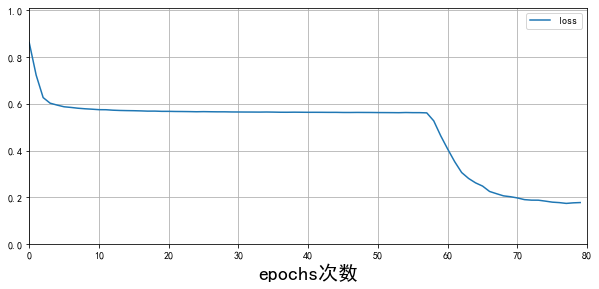

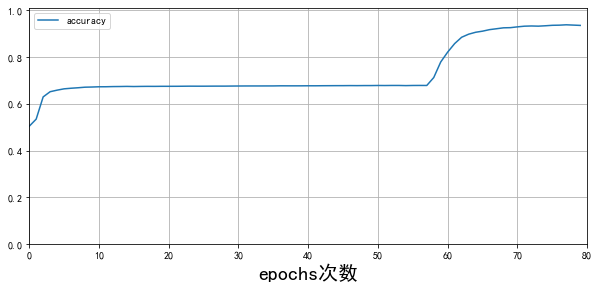

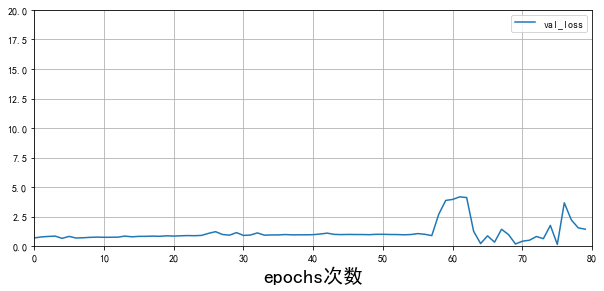

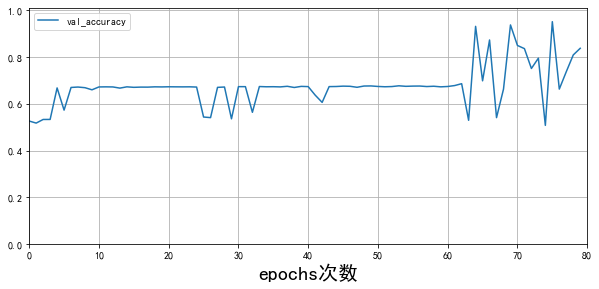

In [54]:
for i,j in enumerate(model_DNN__new_train_history.history):
    plt.figure(figsize=(10,20))
    plt.subplot(4,1,i+1)
    if j == "val_loss":
        plt.grid(True)
        plt.plot(range(len(model_DNN__new_train_history.history[j])),model_DNN__new_train_history.history[j],label = j)
        plt.gca().set_xlim(0, 80)
        plt.gca().set_ylim(0, 20)
    else :
        
        plt.grid(True)
        plt.plot(range(len(model_DNN__new_train_history.history[j])),model_DNN__new_train_history.history[j],label = j)
        plt.gca().set_xlim(0, 80)
        plt.gca().set_ylim(0, 1.01)
    plt.legend()
    plt.xlabel("epochs次数",fontsize = 20)

### S3.验证集表现；——差强人意
- 精准率84%；

In [57]:
model_DNN_new.evaluate(X_train_DNN_new,Y_train_DNN_new)
# model_DNN_new.evaluate(X_test_DNN_new, y_test)# 测试集没有标签无法判断

10263/10263 [==============================] - 7s 674us/step - loss: 1.4110 - accuracy: 0.8403


[1.4110333919525146, 0.8402791619300842]

In [37]:
# X_test_proba = model_DNN_new.predict(X_test_DNN_new)
# classes_x=np.argmax(X_test_proba,axis=1)
# pd.Series(classes_x).value_counts()

### S4.将测试集的预测结果也保存到本地；

In [38]:
# X_test_DNN_new["pred_score_DNN"] = model_DNN_new.predict(X_test_DNN_new)[:,1]
# tst_user_item_feats_df_DNN = pd.concat([tst_user_item_feats_df,X_test_DNN_new["pred_score_DNN"]],axis=1)
# tst_user_item_feats_df_DNN_new = pd.DataFrame(tst_user_item_feats_df_DNN[['user_id', 'click_article_id', 'pred_score_DNN']])
# tst_user_item_feats_df_DNN_new.columns = ['user_id', 'click_article_id', 'pred_score']
# tst_user_item_feats_df_DNN_new.to_csv(save_dir + 'dnn_classifier_score.csv', index=False)

# C4.模型融合

## P1.读取多个模型的排序结果文件

In [39]:
# 分别读取在排序阶段和分类阶段各自得到的排序结果；
lgb_ranker = pd.read_csv(save_dir + 'lgb_ranker_score.csv')
lgb_cls = pd.read_csv(save_dir + 'lgb_classfier_score.csv')
dnn_cls = pd.read_csv(save_dir + 'dnn_classifier_score.csv')
# 建立融合字典包；
rank_model = {'lgb_ranker': lgb_ranker, 'lgb_cls': lgb_cls, 'dnn_cls': dnn_cls}

## P2.融合过程；

In [40]:
# final_recall[final_recall["user_id"]==200000]
# final_recall[final_recall["user_id"]==200000].groupby(['user_id', 'click_article_id'])['pred_score'].sum().reset_index()
# 不加DNN的版本；
# def get_blend_predict_topk(rank_model, topk=5):
#     # 将ranker模型中的分数标准归一化
#     rank_model['lgb_ranker']['pred_score'] = rank_model['lgb_ranker']['pred_score'].transform(lambda x: norm_sim(x))
#     # 把lgb_classifier结果和lgb_ranker结果归一化后的结果先堆到一起；
#     final_recall = rank_model["lgb_cls"].append(rank_model['lgb_ranker'])
#     # 堆到一起后，按照用户,文章物品，groupby预测的分数，这里就明白了为什么分数要最终都命名为pred_score；
#     final_recall = final_recall.groupby(['user_id', 'click_article_id'])['pred_score'].sum().reset_index()
#     submit_sequence_result(final_recall, '排序和分类融合',topk=topk, model_name='blend_fuse_model')
def get_blend_predict_topk(rank_model, topk=5):
    final_recall = rank_model['lgb_cls'].append(rank_model['dnn_cls'])
    # 将ranker模型中的分数标准归一化
    rank_model['dnn_cls']['pred_score'] = rank_model['dnn_cls']['pred_score'].transform(lambda x: norm_sim(x))
    rank_model['lgb_ranker']['pred_score'] = rank_model['lgb_ranker']['pred_score'].transform(lambda x: norm_sim(x))
    # 把lgb_classifier结果和lgb_ranker结果归一化后的结果先堆到一起；
    final_recall = rank_model["lgb_cls"].append(rank_model['lgb_ranker'])
    # 堆到一起后，按照用户,文章物品，groupby预测的分数，这里就明白了为什么分数要最终都命名为pred_score；
    final_recall = final_recall.groupby(['user_id', 'click_article_id'])['pred_score'].sum().reset_index()
    submit_sequence_result(final_recall, '排序和分类融合',topk=topk, model_name='blend_fuse_model')
get_blend_predict_topk(rank_model)
print("初步融合的结果已经生成！也可以参考！")

初步融合的结果已经生成！也可以参考！


# C5.模型Staking
- 思想是将上述两个模型的结果，分数排序，当做新的特征！，再借助另外一个线性模型比如，逻辑回归等进行最终分数输出；
- DNN部分就暂时不考虑了；感觉有些过拟合；所以为了避免干扰先不考虑了；

In [41]:
# 读取多个模型的交叉验证生成的结果文件
# 训练集；上面Ranker模型&Classifier模型交叉验证得到的结果；
trn_lgb_ranker_feats = pd.read_csv(save_dir + 'trn_lgb_ranker_feats_result.csv')
trn_lgb_cls_feats = pd.read_csv(save_dir + 'trn_lgb_classifier_feats_result.csv')
# 测试集；上面Ranker模型&Classifier模型交叉验证得到的结果；
tst_lgb_ranker_feats = pd.read_csv(save_dir + 'tst_lgb_ranker_feats_result.csv')
tst_lgb_cls_feats = pd.read_csv(save_dir + 'tst_lgb_classifier_feats_result.csv')
# 将多个模型输出的特征进行拼接，准备两个拼接的母体，一个测试集的finall_tst_ranker_feats，一个训练集的finall_trn_ranker_feats；
# 只留下['user_id', 'click_article_id', 'label']，后续分数和排名往上拼接；
# 为啥叫ranker，因为排序主题！！！！！！
finall_trn_ranker_feats = trn_lgb_ranker_feats[['user_id', 'click_article_id', 'label']]
finall_tst_ranker_feats = tst_lgb_ranker_feats[['user_id', 'click_article_id']]

In [42]:
# 训练集母体：user_id,click_article_id,label+ pred_score_rank，其中要根据上面定义的融合字典包含的模型和后面的训练测试集顺序相对应；
# [*zip(list(rank_model.keys()),[trn_lgb_ranker_feats, trn_lgb_cls_feats])]字典定义的顺序和后面的列表要对应；
for model_name,trn_model in [*zip(list(rank_model.keys()),[trn_lgb_ranker_feats, trn_lgb_cls_feats, ])]:
    for feat_col in ['pred_score', 'pred_rank']:
        col_name = feat_col + '_' + str(model_name)
        finall_trn_ranker_feats[col_name] = trn_model[feat_col]
for model_name,trn_model in [*zip(list(rank_model.keys()),[tst_lgb_ranker_feats, tst_lgb_cls_feats])]:
    for feat_col in ['pred_score', 'pred_rank']:
        col_name = feat_col + '_' + str(model_name)
        finall_tst_ranker_feats[col_name] = trn_model[feat_col]

In [43]:
# 定义一个逻辑回归模型再次拟合交叉验证产生的特征对测试集进行预测
# 这里需要注意的是，在做交叉验证的时候可以构造多一些与输出预测值相关的特征，来丰富这里简单模型的特征
from sklearn.linear_model import LogisticRegression
feat_cols = ['pred_score_lgb_ranker', 'pred_rank_lgb_ranker', 'pred_score_lgb_cls', 'pred_rank_lgb_cls']
trn_x = finall_trn_ranker_feats[feat_cols]
trn_y = finall_trn_ranker_feats['label']
tst_x = finall_tst_ranker_feats[feat_cols]
# 定义模型
lr = LogisticRegression(C=1.6,class_weight="balanced",max_iter=200)
# 模型训练
lr.fit(trn_x, trn_y)
# 模型预测
finall_tst_ranker_feats['pred_score'] = lr.predict_proba(tst_x)[:, 1]


In [44]:
# 预测结果重新排序, 及生成提交结果
rank_results = finall_tst_ranker_feats[['user_id', 'click_article_id', 'pred_score']]
submit_sequence_result(rank_results, '配合逻辑回归拟合结果',topk=5, model_name='blend_fuse_model_LogiRegression')